In [12]:
"Option pricing models"

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse
import scipy.linalg as linalg
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import RectBivariateSpline
import warnings
warnings.filterwarnings('ignore')

In [19]:
# --- 1. Define Heston Model Parameters and Option Details ---

# Model parameters
v0 = 0.04       # Initial variance (20% volatility)
theta = 0.04    # Long-run variance
kappa = 2.0     # Speed of mean reversion
sigma = 0.3     # Volatility of variance
rho = -0.7      # Correlation between asset and variance (typically negative)
#Market parameters
S0 = 100.0      # Initial stock price
K = 80.0        # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.03        # Risk-free rate (3%)
q = 0.02        # Dividend yield (2%)


In [ ]:
# --- 2. Define the Heston Characteristic Function ---

def char_func_heston(u, T, r, v0, theta, kappa, sigma, rho, stable=True):
    
    if stable==True:
        """
        Computes the Heston characteristic function using a numerically stable formulation
        """
        # This version uses hyperbolic functions for improved numerical stability
        # Numerically stable calculation of C and D

        i = 1j  # Imaginary unit
        
        # Common terms
        beta = kappa - rho * sigma * i * u
        d = np.sqrt(beta**2 + sigma**2 * (u**2 + i * u))
        d_t_half = d * T / 2.0
        
        # Handle the case where d_t_half is very small to avoid division by zero in sinh
        # For small x, sinh(x) approx x and cosh(x) approx 1
        # This prevents NaN values for u=0
        small_d_mask = np.abs(d_t_half) < 1e-10
        
        # Calculate sinh and cosh safely
        sinh_d_tau_half = np.sinh(d_t_half)
        cosh_d_tau_half = np.cosh(d_t_half)
        # Note: coth(x) = 1/tanh(x) = cosh(x)/sinh(x)
        """
        # Avoid numerical issues when d*T is very small
        if np.abs(d_half_T) < 1e-8:
            # Use Taylor expansion for small arguments
            sinh_d_tau_half = d_t_half * (1 + (d_t_half)**2 / 6)
            cosh_d_tau_half = 1 + (d_t_half)**2 / 2
        else:
            sinh_d_tau_half = np.sinh(d_t_half)
            cosh_d_tau_half = np.cosh(d_t_half)
        """

        # D term
        # When d is small, d*coth(d*T/2) -> 2/T
        D_val = -(u**2 + i * u) / (beta + d * cosh_d_tau_half / sinh_d_tau_half)
        D_val[small_d_mask] = -(u[small_d_mask]**2 + i * u[small_d_mask]) / (beta[small_d_mask] + 2.0/T)

        # C term
        # When d is small, the log term simplifies
        log_term = cosh_d_tau_half + (beta / d) * sinh_d_tau_half
        log_term[small_d_mask] = 1.0 # Log(1)=0, so the term vanishes
        
        C_val = (kappa * theta / sigma**2) * (beta * T - 2 * np.log(log_term))

        # The characteristic function
        phi = np.exp(C_val + D_val * v0 + i * u * (np.log(S0) + r * T))
    
    else:
        """
        Computes the Heston characteristic function
        """
        i = 1j  # Imaginary unit
        
        # Calculate d and g
        beta = kappa - rho * sigma * i * u
        d = np.sqrt((rho * sigma * i * u - kappa)**2 + sigma**2 * (u**2 + i * u))
        g = (beta - d) / (beta + d)

        # Calculate C and D
        C = ((kappa * theta / sigma**2) * ((beta - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))))
        D = ((beta - d) / sigma**2) * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))

        # The characteristic function
        phi = np.exp(C + D * v0 + (i * u) * (r * T + np.log(S0)))
        
    return phi

# --- 3. Implement the FFT-based Pricing Method ---
# This function calls the stable characteristic function

def price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho, N = 2**12, eta = 0.25, alpha = 1.5, simpson=True):
    """
    Prices European call options using the Heston model and FFT.
    Returns a range of strikes and their corresponding call prices.

    K: Strike price
    T: Time to maturity
    N: Number of points for FFT
    alpha: Damping parameter
    # FFT parameters
    N = 2**12             # Number of points, should be a power of 2
    alpha = 1.5           # Dampening factor for integrability
    eta = 0.25            # Grid spacing in Fourier domain
    """

    i = 1j  # Imaginary unit
    lambda_ = (2 * np.pi) / (N * eta)  # Step-size in log strike space

    # Grids
    v = np.arange(N) * eta # Integration points
    #k = np.log(S0) - (N / 2) * lambda_ + np.arange(N) * lambda_  # Strike price range
    k = -(N * lambda_ / 2) + lambda_ * np.arange(N)
    strikes = np.exp(k)
    
    # Calculate the Fourier transform of the call price
    u_for_psi = v - (alpha + 1) * i
    numerator = np.exp(-r * T) * char_func_heston(u_for_psi, T, r, v0, theta, kappa, sigma, rho)
    denominator = (alpha + i * v) * (alpha + 1 + i * v)
    psi = numerator / denominator # Damping function

    if simpson == True:
        # Simpson's rule weights
        # Apply Simpson's rule weighting for better accuracy
        simpson_weights = (eta / 3) * (3 + (-1)**(np.arange(N) + 1) - (np.arange(N) == 0))
        fft_input = np.exp(i * v * (N / 2) * lambda_) * psi * simpson_weights
            
    else:
        eta = np.full(N, eta)
        fft_input = np.exp(i * v * (N / 2) * lambda_) * psi * eta

    # FFT
    call_prices_fft = np.fft.fft(fft_input)
    
    call_prices = np.exp(-alpha * k) / np.pi * np.real(call_prices_fft)
    #call_prices = np.exp(-alpha * k) * np.real(call_prices_fft) / np.pi
    
    return strikes, call_prices


Heston Model Parameters:
v0=0.04, theta=0.04, kappa=2.0, sigma=0.3, rho=-0.7, r=0.03, T=1.0

Price for an at-the-money (K=100) call option: 9.2434


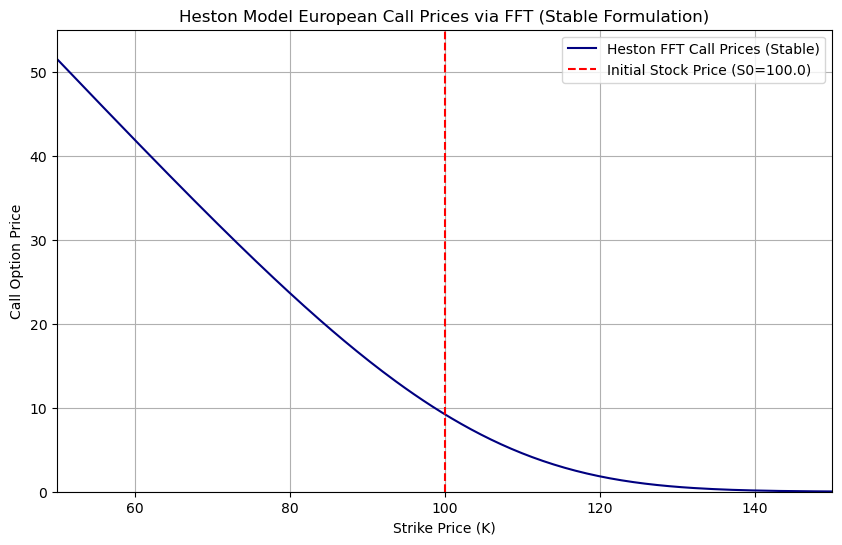

In [ ]:
# --- 4. Price the option and visualize the results ---

if __name__ == '__main__':
    # Get the prices for a range of strikes using the stable method
    strikes, call_prices = price_call_heston_fft(S0, T, r, v0, theta, kappa, sigma, rho)
    
    # Find the price for an at-the-money strike (K=100)
    atm_strike = 100
    atm_price = np.interp(atm_strike, strikes, call_prices)
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Price for an at-the-money (K={atm_strike}) call option: {atm_price:.4f}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, call_prices, label='Heston FFT Call Prices (Stable)', color='navy')
    plt.axvline(x=S0, color='r', linestyle='--', label=f'Initial Stock Price (S0={S0})')
    plt.xlabel('Strike Price (K)')
    plt.ylabel('Call Option Price')
    plt.title('Heston Model European Call Prices via FFT (Stable Formulation)')
    plt.grid(True)
    plt.legend()
    plt.xlim([50, 150])
    plt.ylim([0, 55])
    plt.show()

In [17]:
# --- 1. Main Pricing Function using ADI Method ---

def price_american_put_heston_adi(S0, K, T, r, v0, theta, kappa, sigma, rho, N_S = 500, N_v = 100, N_t = 100, S_max=None):
    """
    Prices an American put option using the Heston model via an ADI finite difference method
    """

    # Define the Finite Difference Grid
    # Grid parameters
    # N_S = 500       # Number of stock price steps
    # N_v = 100        # Number of variance steps
    # N_t = 100       # Number of time steps

    # Grid boundaries
    if S_max is None:
        #S_max = 2 * max(S0, K)   # Max stock price
        S_max = 2 * S0   # Max stock price
    v_max = 0.5      # Max variance

    # Create grids
    S_grid = np.linspace(0, S_max, N_S + 1)
    v_grid = np.linspace(0, v_max, N_v + 1)
    t_grid = np.linspace(0, T, N_t + 1)

    dS = S_grid[1] - S_grid[0]
    dv = v_grid[1] - v_grid[0]
    dt = t_grid[1] - t_grid[0]
    
    # Initialize option value grid at maturity
    # V = np.zeros((N_S + 1, N_v + 1))
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')
    V = np.maximum(K - S_mat, 0)
    
    # --- Time Marching Loop (from T to 0) ---
    for n in range(N_t, 0, -1):
        # -- Intermediate Step (Y) --
        # Implicit in S, Explicit in v
        
        # Temporary grid for intermediate values
        Y = np.zeros_like(V)
        
        # Loop over interior variance points
        for j in range(1, N_v):
            vj = v_grid[j]
            
            # Coefficients for the S-dimension PDE part
            lower_S = (dt / 2) * ((vj / 2) * S_grid[1:-1]**2 / dS**2 - r * S_grid[1:-1] / (2 * dS))
            main_S = -(dt / 2) * (vj * S_grid[1:-1]**2 / dS**2 + r)
            upper_S = (dt / 2) * ((vj / 2) * S_grid[1:-1]**2 / dS**2 + r * S_grid[1:-1] / (2 * dS))

            # --- Create A_S as a sparse matrix using diags ---
            diagonals_S = [-lower_S[1:], 1 - main_S, -upper_S[:-1]]
            offsets = [-1, 0, 1]
            A_S_sparse = diags(diagonals_S, offsets, shape=(N_S - 1, N_S - 1), format='csc')
            
            # Setup RHS (Right-Hand Side)
            B_S_V = (V[1:-1, j] + 
                     lower_S * V[:-2, j] + 
                     main_S * V[1:-1, j] + 
                     upper_S * V[2:, j])
            
            # RHS vector from explicit v-parts and cross-derivative


            dv_V = (V[1:-1, j+1] - V[1:-1, j-1]) / (2 * dv)
            d2v_V = (V[1:-1, j+1] - 2 * V[1:-1, j] + V[1:-1, j-1]) / dv**2
            dSv_V = (V[2:, j+1] - V[:-2, j+1] - V[2:, j-1] + V[:-2, j-1]) / (4 * dS * dv)

            L_v_V = (0.5 * sigma**2 * vj * d2v_V + 
                     kappa * (theta - vj) * dv_V +
                     0.5 * rho * sigma * vj * S_grid[1:-1] * dSv_V)
            
            rhs = B_S_V + dt * L_v_V

            rhs[0] += 2 * lower_S[0] * K 
            rhs[-1] += 2 * upper_S[-1] * 0
            
            # Solve using spsolve
            Y[1:-1, j] = spsolve(A_S_sparse, rhs)

        # Apply boundary conditions for Y
        Y[0, :] = K
        Y[-1, :] = 0
        Y[:, 0] = K * np.exp(-r * (T - t_grid[n-1])) # Feller condition at v=0
        Y[:, -1] = Y[:, -2] # Extrapolate at v_max
        
        # -- Final Step (V) --
        # Implicit in v, Explicit in S (using Y values)
        
        # Loop over interior stock price points
        for i in range(1, N_S):
            Si = S_grid[i]
            
            # Coefficients for the v-dimension PDE part
            lower_v = (dt / 2) * ((sigma**2 / 2) * v_grid[1:-1] / dv**2 - kappa * (theta - v_grid[1:-1]) / (2 * dv))
            main_v = -(dt / 2) * (sigma**2 * v_grid[1:-1] / dv**2 + r)
            upper_v = (dt / 2) * ((sigma**2 / 2) * v_grid[1:-1] / dv**2 + kappa * (theta - v_grid[1:-1]) / (2 * dv))
            
            # --- Create A_v as a sparse matrix using diags ---
            diagonals_v = [-lower_v[1:], 1 - main_v, -upper_v[:-1]]
            offsets_v = [-1, 0, 1]
            A_v_sparse = diags(diagonals_v, offsets_v, shape=(N_v - 1, N_v - 1), format='csc')

            # Get the explicit S-part from the intermediate solution Y
            dS_Y = (Y[i+1, 1:-1] - Y[i-1, 1:-1]) / (2 * dS)
            d2S_Y = (Y[i+1, 1:-1] - 2 * Y[i, 1:-1] + Y[i-1, 1:-1]) / dS**2
            
            # We subtract the explicit part that was already added in the Y step
            L_S_V = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * V[i, 1:-1]
            L_S_Y = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * Y[i, 1:-1]

             # B_v_V is the explicit part for the v-direction
            B_v_V = V[i, 1:-1] + lower_v*V[i, :-2] + main_v*V[i, 1:-1] + upper_v*V[i, 2:]
            
            rhs_v = B_v_V + (L_S_Y - L_S_V)

            # Boundary conditions for v-direction
            rhs_v[0] += 2 * lower_v[0] * (K * np.exp(-r * (T - t_grid[n-1])) - Y[i,0])
            # No specific condition for v_max, natural boundary
            
            # Solve using spsolve
            V[i, 1:-1] = spsolve(A_v_sparse, rhs_v)
            
        # --- Enforce American Early Exercise Constraint ---
        intrinsic_value = np.maximum(K - S_mat, 0)
        V = np.maximum(V, intrinsic_value)

    # --- Interpolate to find the price at (S0, v0) ---
    spline = RectBivariateSpline(S_grid, v_grid, V)
    price = spline(S0, v0)[0][0]
    
    return price, V


In [36]:
# --- 1. Main Pricing Function using ADI Method --

def price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                      N_S = 500, N_v = 100, N_t = 100, S_max=None):
    """
    Prices an American put option using the Heston model,
    solving the linear systems with scipy.sparse.linalg.spsolve.
    """
    # Define the Finite Difference Grid
    # Grid parameters
    # N_S = 500       # Number of stock price steps
    # N_v = 100       # Number of variance steps
    # N_t = 100       # Number of time steps

    # Grid boundaries
    if S_max is None:
        #S_max = 2 * max(S0, K)   # Max stock price
        S_max = 2 * S0   # Max stock price
    v_max = 0.5      # Max variance

    S_grid = np.linspace(0, S_max, N_S + 1)
    v_grid = np.linspace(0, v_max, N_v + 1)
    t_grid = np.linspace(0, T, N_t + 1)

    dS = S_grid[1] - S_grid[0]
    dv = v_grid[1] - v_grid[0]
    dt = t_grid[1] - t_grid[0]
    
    #V = np.zeros((N_S + 1, N_v + 1))
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')
    V = np.maximum(K - S_mat, 0)
    
    for n in range(N_t, 0, -1):
        # -- Intermediate Step (Y) --
        Y = np.zeros_like(V)
        
        for j in range(1, N_v):
            vj = v_grid[j]
            
            alpha_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 - r * S_grid[1:-1] / dS)
            beta_S = -0.5 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r)
            gamma_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r * S_grid[1:-1] / dS)
            
            # --- FIX 1: Create A_S as a sparse matrix using diags ---
            diagonals_S = [-alpha_S[1:], 1 - beta_S, -gamma_S[:-1]]
            offsets = [-1, 0, 1]
            A_S_sparse = diags(diagonals_S, offsets, shape=(N_S - 1, N_S - 1), format='csc')
            
            # Setup RHS (Right-Hand Side)
            B_S_V = (V[1:-1, j] + 
                     alpha_S * V[:-2, j] + 
                     beta_S * V[1:-1, j] + 
                     gamma_S * V[2:, j])

            dv_V = (V[1:-1, j+1] - V[1:-1, j-1]) / (2 * dv)
            d2v_V = (V[1:-1, j+1] - 2 * V[1:-1, j] + V[1:-1, j-1]) / dv**2
            dSv_V = (V[2:, j+1] - V[:-2, j+1] - V[2:, j-1] + V[:-2, j-1]) / (4 * dS * dv)

            L_v_V = (0.5 * sigma**2 * vj * d2v_V + kappa * (theta - vj) * dv_V +
                     0.5 * rho * sigma * vj * S_grid[1:-1] * dSv_V)
            
            rhs = B_S_V + dt * L_v_V

            rhs[0] += 2 * alpha_S[0] * K 
            rhs[-1] += 2 * gamma_S[-1] * 0
            
            # Solve using spsolve
            Y[1:-1, j] = spsolve(A_S_sparse, rhs)

        Y[0, :] = K
        Y[-1, :] = 0
        Y[:, 0] = K * np.exp(-r * (T - t_grid[n-1]))
        Y[:, -1] = Y[:, -2]
        
        # -- Final Step (V) --
        for i in range(1, N_S):
            Si = S_grid[i]
            
            alpha_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 - kappa * (theta - v_grid[1:-1]) / dv)
            beta_v = -0.5 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + r)
            gamma_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + kappa * (theta - v_grid[1:-1]) / dv)

            # --- FIX 2: Create A_v as a sparse matrix using diags ---
            diagonals_v = [-alpha_v[1:], 1 - beta_v, -gamma_v[:-1]]
            offsets_v = [-1, 0, 1]
            A_v_sparse = diags(diagonals_v, offsets_v, shape=(N_v - 1, N_v - 1), format='csc')

            dS_Y = (Y[i+1, 1:-1] - Y[i-1, 1:-1]) / (2 * dS)
            d2S_Y = (Y[i+1, 1:-1] - 2 * Y[i, 1:-1] + Y[i-1, 1:-1]) / dS**2
            
            L_S_V = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * V[i, 1:-1]
            L_S_Y = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * Y[i, 1:-1]
            
            # B_v_V is the explicit part for the v-direction
            B_v_V = V[i, 1:-1] + alpha_v*V[i, :-2] + beta_v*V[i, 1:-1] + gamma_v*V[i, 2:]
            
            rhs_v = B_v_V + (L_S_Y - L_S_V)
            
            rhs_v[0] += 2 * alpha_v[0] * (K * np.exp(-r * (T - t_grid[n-1])) - Y[i,0])
            
            # Solve using spsolve
            V[i, 1:-1] = spsolve(A_v_sparse, rhs_v)
            
        intrinsic_value = np.maximum(K - S_mat, 0)
        V = np.maximum(V, intrinsic_value)

    spline = RectBivariateSpline(S_grid, v_grid, V)
    price = spline(S0, v0)[0][0]
    
    return price, V


Heston Model Parameters:
v0=0.04, theta=0.04, kappa=2.0, sigma=0.3, rho=-0.7, r=0.05, T=1.0

Grid Size: 150 (Stock Price) x 50 (Variance) x 100 (Time)
Price for an at-the-money (S0=100.0, K=100.0) American Put Option: 0.0000


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (101, 51) and arg 2 with shape (501, 101).

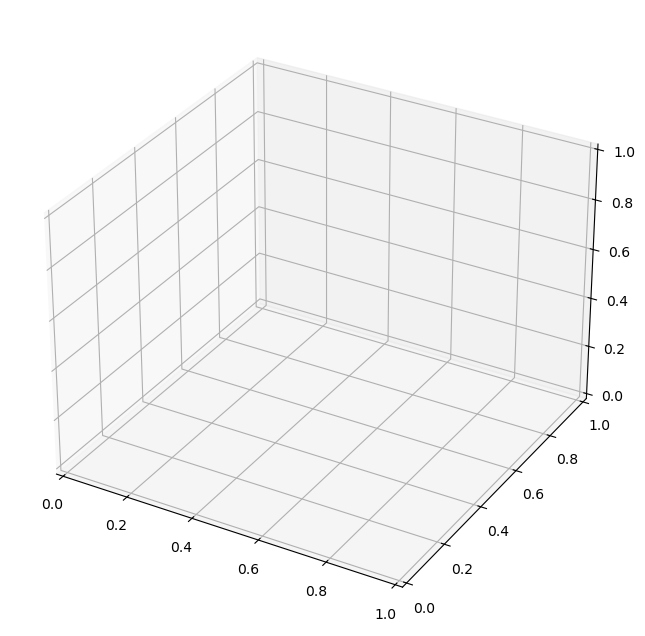

In [37]:
# --- 2. Define Heston Model Parameters and Option Details ---
v0 = 0.04       # Initial variance
theta = 0.04    # Long-run variance
kappa = 2.0     # Speed of mean reversion
sigma = 0.3     # Volatility of variance
rho = -0.7      # Correlation
S0 = 100.0      # Initial stock price
K = 100.0       # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.05        # Risk-free rate

# --- 3. Price the option and visualize the results ---
if __name__ == '__main__':
    price, V_grid = price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho)
    
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Grid Size: {N_S} (Stock Price) x {N_v} (Variance) x {N_t} (Time)")
    print(f"Price for an at-the-money (S0={S0}, K={K}) American Put Option: {price:.4f}")

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')

    ax.plot_surface(S_mat, v_mat, V_grid, cmap='viridis')
    ax.set_title("Heston American Put Option Value Surface (Solved with spsolve)")
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel("Variance (v)")
    ax.set_zlabel("Option Price")
    ax.view_init(30, -120)
    plt.show()

Heston Model Parameters:
v0=0.04, theta=0.04, kappa=2.0, sigma=0.3, rho=-0.7, r=0.05, T=1.0

Grid Size: 100 (Stock Price) x 50 (Variance) x 100 (Time)
Price for an at-the-money (S0=100.0, K=100.0) American Put Option: 0.0000


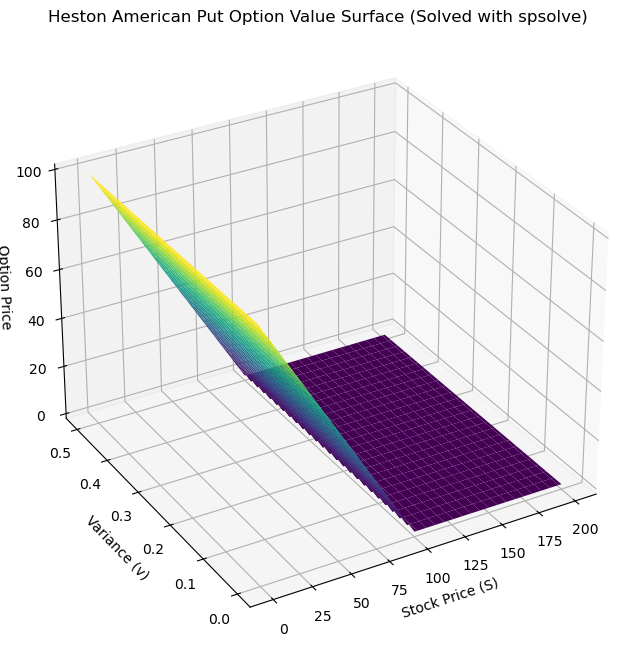

In [38]:

# --- 1. Define Heston Model Parameters and Option Details ---
v0 = 0.04       # Initial variance
theta = 0.04    # Long-run variance
kappa = 2.0     # Speed of mean reversion
sigma = 0.3     # Volatility of variance
rho = -0.7      # Correlation
S0 = 100.0      # Initial stock price
K = 100.0       # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.05        # Risk-free rate

# --- 2. Define the Finite Difference Grid ---
N_S = 100
N_v = 50
N_t = 100
S_max = 2 * S0
v_max = 0.5

S_grid = np.linspace(0, S_max, N_S + 1)
v_grid = np.linspace(0, v_max, N_v + 1)
t_grid = np.linspace(0, T, N_t + 1)

dS = S_grid[1] - S_grid[0]
dv = v_grid[1] - v_grid[0]
dt = t_grid[1] - t_grid[0]

# --- 3. Main Pricing Function using spsolve ---
def price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                      S_grid, v_grid, t_grid):
    """
    Prices an American put option using the Heston model,
    solving the linear systems with scipy.sparse.linalg.spsolve.
    """
    N_S = len(S_grid) - 1
    N_v = len(v_grid) - 1
    N_t = len(t_grid) - 1
    
    V = np.zeros((N_S + 1, N_v + 1))
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')
    V = np.maximum(K - S_mat, 0)
    
    for n in range(N_t, 0, -1):
        # -- Intermediate Step (Y) --
        Y = np.zeros_like(V)
        
        for j in range(1, N_v):
            vj = v_grid[j]
            
            alpha_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 - r * S_grid[1:-1] / dS)
            beta_S = -0.5 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r)
            gamma_S = 0.25 * dt * (vj * S_grid[1:-1]**2 / dS**2 + r * S_grid[1:-1] / dS)
            
            # --- FIX 1: Create A_S as a sparse matrix using diags ---
            diagonals_S = [-alpha_S[1:], 1 - beta_S, -gamma_S[:-1]]
            offsets = [-1, 0, 1]
            A_S_sparse = diags(diagonals_S, offsets, shape=(N_S - 1, N_S - 1), format='csc')
            
            # Setup RHS (Right-Hand Side)
            B_S_V = (V[1:-1, j] + 
                     alpha_S * V[:-2, j] + 
                     beta_S * V[1:-1, j] + 
                     gamma_S * V[2:, j])

            dv_V = (V[1:-1, j+1] - V[1:-1, j-1]) / (2 * dv)
            d2v_V = (V[1:-1, j+1] - 2 * V[1:-1, j] + V[1:-1, j-1]) / dv**2
            dSv_V = (V[2:, j+1] - V[:-2, j+1] - V[2:, j-1] + V[:-2, j-1]) / (4 * dS * dv)

            L_v_V = (0.5 * sigma**2 * vj * d2v_V + kappa * (theta - vj) * dv_V +
                     0.5 * rho * sigma * vj * S_grid[1:-1] * dSv_V)
            
            rhs = B_S_V + dt * L_v_V

            rhs[0] += 2 * alpha_S[0] * K 
            rhs[-1] += 2 * gamma_S[-1] * 0
            
            # Solve using spsolve
            Y[1:-1, j] = spsolve(A_S_sparse, rhs)

        Y[0, :] = K
        Y[-1, :] = 0
        Y[:, 0] = K * np.exp(-r * (T - t_grid[n-1]))
        Y[:, -1] = Y[:, -2]
        
        # -- Final Step (V) --
        for i in range(1, N_S):
            Si = S_grid[i]
            
            alpha_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 - kappa * (theta - v_grid[1:-1]) / dv)
            beta_v = -0.5 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + r)
            gamma_v = 0.25 * dt * (sigma**2 * v_grid[1:-1] / dv**2 + kappa * (theta - v_grid[1:-1]) / dv)

            # --- FIX 2: Create A_v as a sparse matrix using diags ---
            diagonals_v = [-alpha_v[1:], 1 - beta_v, -gamma_v[:-1]]
            offsets_v = [-1, 0, 1]
            A_v_sparse = diags(diagonals_v, offsets_v, shape=(N_v - 1, N_v - 1), format='csc')

            dS_Y = (Y[i+1, 1:-1] - Y[i-1, 1:-1]) / (2 * dS)
            d2S_Y = (Y[i+1, 1:-1] - 2 * Y[i, 1:-1] + Y[i-1, 1:-1]) / dS**2
            
            L_S_V = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * V[i, 1:-1]
            L_S_Y = 0.5 * v_grid[1:-1] * Si**2 * d2S_Y + r * Si * dS_Y - 0.5 * r * Y[i, 1:-1]
            
            # B_v_V is the explicit part for the v-direction
            B_v_V = V[i, 1:-1] + alpha_v*V[i, :-2] + beta_v*V[i, 1:-1] + gamma_v*V[i, 2:]
            
            rhs_v = B_v_V + (L_S_Y - L_S_V)
            
            rhs_v[0] += 2 * alpha_v[0] * (K * np.exp(-r * (T - t_grid[n-1])) - Y[i,0])
            
            # Solve using spsolve
            V[i, 1:-1] = spsolve(A_v_sparse, rhs_v)
            
        intrinsic_value = np.maximum(K - S_mat, 0)
        V = np.maximum(V, intrinsic_value)

    spline = RectBivariateSpline(S_grid, v_grid, V)
    price = spline(S0, v0)[0][0]
    
    return price, V

# --- 4. Price the option and visualize the results ---
if __name__ == '__main__':
    price, V_grid = price_american_put_heston_spsolve(S0, K, T, r, v0, theta, kappa, sigma, rho,
                                                      S_grid, v_grid, t_grid)
    
    print(f"Heston Model Parameters:")
    print(f"v0={v0}, theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, r={r}, T={T}\n")
    print(f"Grid Size: {N_S} (Stock Price) x {N_v} (Variance) x {N_t} (Time)")
    print(f"Price for an at-the-money (S0={S0}, K={K}) American Put Option: {price:.4f}")

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    S_mat, v_mat = np.meshgrid(S_grid, v_grid, indexing='ij')

    ax.plot_surface(S_mat, v_mat, V_grid, cmap='viridis')
    ax.set_title("Heston American Put Option Value Surface (Solved with spsolve)")
    ax.set_xlabel("Stock Price (S)")
    ax.set_ylabel("Variance (v)")
    ax.set_zlabel("Option Price")
    ax.view_init(30, -120)
    plt.show()

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

class HestonADI:
    """
    Heston Stochastic Volatility Model with ADI (Alternating Direction Implicit) Method
    Using Hundsdorfer-Verwer ADI Scheme for American Options
    """
    
    def __init__(self, S0, v0, rho, kappa, theta, sigma, r, q=0):
        """
        Initialize Heston model parameters
        
        S0: Initial stock price
        v0: Initial variance
        rho: Correlation between stock and volatility
        kappa: Mean reversion speed
        theta: Long-term variance
        sigma: Volatility of variance (vol of vol)
        r: Risk-free rate
        q: Dividend yield
        """
        self.S0 = S0
        self.v0 = v0
        self.rho = rho
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.r = r
        self.q = q
        
    def characteristic_function_hyperbolic(self, u, T):
        """
        Heston characteristic function using hyperbolic formulation
        """
        i = complex(0, 1)
        
        # Auxiliary parameters
        alpha = -0.5 * u * (u + i)
        beta = self.kappa - self.rho * self.sigma * i * u
        gamma = 0.5 * self.sigma**2
        
        # Discriminant with proper branch cut
        d = np.sqrt(beta**2 - 4*alpha*gamma)
        if np.real(d) < 0:
            d = -d
        
        # Half argument for stability
        d_half_T = 0.5 * d * T
        
        # Hyperbolic functions with small argument handling
        if np.abs(d_half_T) < 1e-8:
            sinh_term = d_half_T * (1 + (d_half_T)**2 / 6)
            cosh_term = 1 + (d_half_T)**2 / 2
            tanh_term = d_half_T * (1 - (d_half_T)**2 / 3)
        else:
            sinh_term = np.sinh(d_half_T)
            cosh_term = np.cosh(d_half_T)
            tanh_term = sinh_term / cosh_term
        
        # B coefficient (multiplies v₀)
        B = (2 * alpha * tanh_term) / (d + (beta - d) * tanh_term)
        
        # A coefficient (independent term)
        log_cosh = np.log(cosh_term)
        A = self.kappa * self.theta / gamma * (beta * T - 2 * log_cosh - 0.5 * (beta - d) * T)
        
        # Complete characteristic function
        phi = np.exp((self.r - self.q) * i * u * T + A + B * self.v0)
        
        return phi
    
    def price_european_call_fft(self, K, T, N=2**15, alpha=1.5):
        """
        Price European call option using FFT method
        """
        eta = 0.25
        lam = 2 * np.pi / (N * eta)
        b = N * lam / 2
        
        k = -b + lam * np.arange(N)
        v = eta * np.arange(N)
        
        def psi(u):
            char_func = self.characteristic_function_hyperbolic(u - (alpha + 1) * 1j, T)
            denominator = alpha**2 + alpha - u**2 + 1j * (2 * alpha + 1) * u
            return np.exp(-self.r * T) * char_func / denominator
        
        x = np.zeros(N, dtype=complex)
        x[0] = 0.5 * psi(0)
        
        for i in range(1, N):
            try:
                x[i] = psi(v[i])
            except:
                x[i] = 0
        
        x *= eta
        y = np.fft.fft(x)
        call_values = (np.exp(-alpha * k) / np.pi) * np.real(y)
        
        log_strike = np.log(K)
        call_price = np.interp(log_strike, k, call_values)
        
        return max(call_price, 0)
    
    def setup_adi_grid(self, S_max, v_max, NS, NV, T, NT):
        """
        Setup 2D grid for ADI method
        
        S_max: Maximum stock price
        v_max: Maximum variance
        NS: Number of stock price points
        NV: Number of variance points  
        T: Time to maturity
        NT: Number of time steps
        """
        # Stock price grid (non-uniform, concentrated around S0)
        S_uniform = np.linspace(0, S_max, NS + 1)
        # Apply sinh transformation for better concentration
        xi = np.linspace(-2, 2, NS + 1)
        S = S_max * (1 + np.tanh(xi)) / 2
        S[0] = 0  # Ensure boundary condition
        
        # Variance grid (non-uniform, concentrated around v0)
        eta = np.linspace(0, 3, NV + 1)
        v = v_max * (eta / 3)**2  # Quadratic spacing
        v[0] = 0  # Ensure boundary at v=0
        
        # Time grid
        dt = T / NT
        t = np.linspace(0, T, NT + 1)
        
        # Grid spacings
        dS = np.diff(S)
        dv = np.diff(v)
        
        return S, v, t, dt, dS, dv
    
    def build_adi_operators(self, S, v, dS, dv, dt):
        """
        Build finite difference operators for ADI scheme
        """
        NS, NV = len(S) - 1, len(v) - 1
        
        # Stock direction operators
        LS_operators = []
        for j in range(1, NV):  # Interior variance points
            # Coefficients for stock direction
            diag_main = np.zeros(NS + 1)
            diag_lower = np.zeros(NS)
            diag_upper = np.zeros(NS)
            
            for i in range(1, NS):
                # Drift and diffusion coefficients
                mu_S = (self.r - self.q) * S[i]
                sigma2_S = v[j] * S[i]**2
                
                # Central differences with non-uniform grid
                dS_left = S[i] - S[i-1]
                dS_right = S[i+1] - S[i]
                dS_avg = 0.5 * (dS_left + dS_right)
                
                # Finite difference coefficients
                alpha_i = sigma2_S / (dS_left * dS_avg) - mu_S / (2 * dS_avg)
                beta_i = -sigma2_S / (dS_left * dS_right) - self.r
                gamma_i = sigma2_S / (dS_right * dS_avg) + mu_S / (2 * dS_avg)
                
                diag_lower[i-1] = alpha_i
                diag_main[i] = beta_i
                diag_upper[i] = gamma_i
            
            # Boundary conditions for stock
            diag_main[0] = 1.0  # V(0, v, t) boundary
            diag_main[NS] = 1.0  # V(S_max, v, t) boundary
            
            # Create sparse matrix
            LS = sparse.diags([diag_lower, diag_main, diag_upper], 
                             offsets=[-1, 0, 1], shape=(NS+1, NS+1), format='csr')
            LS_operators.append(LS)
        
        # Variance direction operators
        LV_operators = []
        for i in range(1, NS):  # Interior stock points
            diag_main = np.zeros(NV + 1)
            diag_lower = np.zeros(NV)
            diag_upper = np.zeros(NV)
            
            for j in range(1, NV):
                # Drift and diffusion coefficients for variance
                mu_v = self.kappa * (self.theta - v[j])
                sigma2_v = self.sigma**2 * v[j]
                rho_term = self.rho * self.sigma * np.sqrt(v[j]) * S[i]
                
                # Central differences with non-uniform grid
                dv_left = v[j] - v[j-1]
                dv_right = v[j+1] - v[j]
                dv_avg = 0.5 * (dv_left + dv_right)
                
                # Finite difference coefficients
                alpha_j = sigma2_v / (dv_left * dv_avg) - mu_v / (2 * dv_avg)
                beta_j = -sigma2_v / (dv_left * dv_right) - self.r
                gamma_j = sigma2_v / (dv_right * dv_avg) + mu_v / (2 * dv_avg)
                
                diag_lower[j-1] = alpha_j
                diag_main[j] = beta_j
                diag_upper[j] = gamma_j
            
            # Boundary conditions for variance
            diag_main[0] = 1.0  # V(S, 0, t) boundary
            diag_main[NV] = 1.0  # V(S, v_max, t) boundary
            
            # Create sparse matrix
            LV = sparse.diags([diag_lower, diag_main, diag_upper], 
                             offsets=[-1, 0, 1], shape=(NV+1, NV+1), format='csr')
            LV_operators.append(LV)
        
        return LS_operators, LV_operators
    
    def build_cross_derivative_operator(self, S, v, dS, dv):
        """
        Build cross-derivative operator for ρ∂²V/∂S∂v term
        """
        NS, NV = len(S) - 1, len(v) - 1
        
        # Cross-derivative matrix (sparse)
        cross_terms = []
        
        for i in range(1, NS):
            for j in range(1, NV):
                # Cross-derivative coefficient
                rho_coeff = self.rho * self.sigma * np.sqrt(v[j]) * S[i]
                
                # Mixed partial derivative using central differences
                dS_avg = 0.5 * ((S[i+1] - S[i]) + (S[i] - S[i-1]))
                dv_avg = 0.5 * ((v[j+1] - v[j]) + (v[j] - v[j-1]))
                
                cross_coeff = rho_coeff / (4 * dS_avg * dv_avg)
                
                # Store coefficients for cross terms
                cross_terms.append((i, j, cross_coeff))
        
        return cross_terms
    
    def hundsdorfer_verwer_step(self, V, LS_ops, LV_ops, cross_terms, S, v, dt, K, option_type='put'):
        """
        Hundsdorfer-Verwer ADI scheme step
        This is a second-order ADI scheme with better stability
        """
        NS, NV = len(S) - 1, len(v) - 1
        theta1, theta2 = 0.5, 0.5  # ADI parameters
        
        # Step 1: Intermediate step in S direction
        V_star = V.copy()
        
        for j in range(1, NV):
            # Setup system for this variance slice
            if j-1 < len(LS_ops):
                A_S = sparse.eye(NS + 1) - theta1 * dt * LS_ops[j-1]
                b_S = (sparse.eye(NS + 1) + (1 - theta1) * dt * LS_ops[j-1]) @ V[:, j]
                
                # Apply cross-derivative terms
                for i, jj, coeff in cross_terms:
                    if jj == j and i > 0 and i < NS and j > 0 and j < NV:
                        # Add cross-derivative contribution
                        cross_contrib = coeff * dt * (
                            V[i+1, j+1] - V[i+1, j-1] - V[i-1, j+1] + V[i-1, j-1]
                        )
                        b_S[i] += cross_contrib
                
                # Boundary conditions
                if option_type == 'put':
                    b_S[0] = max(K - S[0], 0)  # V(0, v, t)
                    b_S[NS] = max(K - S[NS], 0)  # V(S_max, v, t) ≈ 0
                else:  # call
                    b_S[0] = max(S[0] - K, 0)  # V(0, v, t) = 0
                    b_S[NS] = max(S[NS] - K, 0)  # V(S_max, v, t) = S_max - K*e^(-r*τ)
                
                # Solve system
                try:
                    V_star[:, j] = spsolve(A_S, b_S)
                except:
                    V_star[:, j] = V[:, j]  # Fallback
        
        # Step 2: Full step in V direction
        V_new = V_star.copy()
        
        for i in range(1, NS):
            # Setup system for this stock price slice
            if i-1 < len(LV_ops):
                A_V = sparse.eye(NV + 1) - theta2 * dt * LV_ops[i-1]
                b_V = (sparse.eye(NV + 1) + (1 - theta2) * dt * LV_ops[i-1]) @ V_star[i, :]
                
                # Boundary conditions for variance direction
                if option_type == 'put':
                    b_V[0] = max(K - S[i], 0)  # V(S, 0, t) = max(K-S, 0)
                    b_V[NV] = max(K - S[i], 0)  # V(S, v_max, t)
                else:  # call
                    b_V[0] = max(S[i] - K, 0)  # V(S, 0, t) = max(S-K, 0)
                    b_V[NV] = max(S[i] - K, 0)  # V(S, v_max, t)
                
                # Solve system
                try:
                    V_new[i, :] = spsolve(A_V, b_V)
                except:
                    V_new[i, :] = V_star[i, :]  # Fallback
        
        # Step 3: Correction step (Hundsdorfer-Verwer)
        # This improves accuracy to second order
        V_corrected = V_new.copy()
        
        # Apply correction terms
        correction = 0.5 * dt * (theta1 - 0.5) * (theta2 - 0.5)
        
        for i in range(1, NS):
            for j in range(1, NV):
                if i-1 < len(LV_ops) and j-1 < len(LS_ops):
                    # Mixed correction term
                    LS_term = LS_ops[j-1] @ V_new[:, j]
                    LV_term = LV_ops[i-1] @ V_new[i, :]
                    
                    if i < len(LS_term) and j < len(LV_term):
                        V_corrected[i, j] += correction * (LS_term[i] + LV_term[j])
        
        # Apply American constraint (early exercise)
        intrinsic = np.zeros((NS + 1, NV + 1))
        for i in range(NS + 1):
            for j in range(NV + 1):
                if option_type == 'put':
                    intrinsic[i, j] = max(K - S[i], 0)
                else:  # call
                    intrinsic[i, j] = max(S[i] - K, 0)
        
        V_corrected = np.maximum(V_corrected, intrinsic)
        
        return V_corrected
    
    def price_american_option_adi(self, K, T, S_max=None, v_max=None, NS=60, NV=30, NT=100, option_type='put'):
        """
        Price American option using Hundsdorfer-Verwer ADI method
        
        K: Strike price
        T: Time to maturity
        S_max: Maximum stock price for grid
        v_max: Maximum variance for grid
        NS: Number of stock price steps
        NV: Number of variance steps
        NT: Number of time steps
        option_type: 'put' or 'call'
        """
        if S_max is None:
            S_max = 3 * max(self.S0, K)
        if v_max is None:
            v_max = 3 * max(self.v0, self.theta)
        
        print(f"Setting up {NS+1}×{NV+1}×{NT+1} ADI grid...")
        
        # Setup grid
        S, v, t, dt, dS, dv = self.setup_adi_grid(S_max, v_max, NS, NV, T, NT)
        
        # Build finite difference operators
        print("Building ADI operators...")
        LS_operators, LV_operators = self.build_adi_operators(S, v, dS, dv, dt)
        cross_terms = self.build_cross_derivative_operator(S, v, dS, dv)
        
        # Initialize option values at maturity
        V = np.zeros((NS + 1, NV + 1))
        for i in range(NS + 1):
            for j in range(NV + 1):
                if option_type == 'put':
                    V[i, j] = max(K - S[i], 0)
                else:  # call
                    V[i, j] = max(S[i] - K, 0)
        
        print("Starting ADI time-stepping...")
        
        # Time-stepping using Hundsdorfer-Verwer ADI
        for n in range(NT):
            if (n + 1) % 20 == 0:
                print(f"Time step {n+1}/{NT}")
            
            try:
                V = self.hundsdorfer_verwer_step(V, LS_operators, LV_operators, 
                                               cross_terms, S, v, dt, K, option_type)
            except Exception as e:
                print(f"Warning: ADI step {n} failed: {e}")
                break
        
        # Interpolate to get option price at (S0, v0)
        # Find closest grid points
        i_S = np.argmin(np.abs(S - self.S0))
        j_v = np.argmin(np.abs(v - self.v0))
        
        # Bilinear interpolation
        if i_S < NS and j_v < NV:
            # Weights for bilinear interpolation
            w_S = (self.S0 - S[i_S]) / (S[i_S + 1] - S[i_S]) if S[i_S + 1] != S[i_S] else 0
            w_v = (self.v0 - v[j_v]) / (v[j_v + 1] - v[j_v]) if v[j_v + 1] != v[j_v] else 0
            
            option_price = (
                (1 - w_S) * (1 - w_v) * V[i_S, j_v] +
                w_S * (1 - w_v) * V[i_S + 1, j_v] +
                (1 - w_S) * w_v * V[i_S, j_v + 1] +
                w_S * w_v * V[i_S + 1, j_v + 1]
            )
        else:
            option_price = V[i_S, j_v]
        
        print("ADI pricing complete!")
        
        return option_price, S, v, V
    
def main():
    """
    Main function demonstrating Heston ADI implementation
    """
    print("Heston Model: American Options with ADI (Hundsdorfer-Verwer)")
    print("=" * 65)
    
    # Market parameters
    S0 = 100.0      # Current stock price
    K = 100.0       # Strike price
    T = 0.25        # Time to maturity (3 months)
    r = 0.05        # Risk-free rate (5%)
    q = 0.02        # Dividend yield (2%)
    
    # Heston model parameters
    v0 = 0.04       # Initial variance (20% volatility)
    kappa = 2.5     # Mean reversion speed
    theta = 0.04    # Long-term variance
    sigma = 0.3     # Volatility of variance
    rho = -0.7      # Correlation
    
    print(f"Market Parameters:")
    print(f"S0=${S0}, K=${K}, T={T}y, r={r:.1%}, q={q:.1%}")
    print(f"Heston Parameters:")
    print(f"v0={v0:.4f}, κ={kappa}, θ={theta:.4f}, σ={sigma}, ρ={rho}")
    
    # Check Feller condition
    feller = 2 * kappa * theta
    print(f"Feller Condition: 2κθ={feller:.3f} vs σ²={sigma**2:.3f} ✓" if feller >= sigma**2 else " ✗")
    print()
    
    # Initialize model
    heston = HestonADI(S0, v0, rho, kappa, theta, sigma, r, q)
    
    # 1. European Call Option (FFT for comparison)
    print("1. European Call Option (FFT)")
    print("-" * 35)
    try:
        call_european = heston.price_european_call_fft(K, T)
        print(f"European Call Price: ${call_european:.4f}")
        
        # Put-call parity
        put_european = call_european - S0 * np.exp(-q * T) + K * np.exp(-r * T)
        print(f"European Put Price:  ${put_european:.4f}")
    except Exception as e:
        print(f"FFT Error: {e}")
        call_european, put_european = None, None
    print()
    
    # 2. American Put Option (ADI)
    print("2. American Put Option (ADI Method)")
    print("-" * 40)
    try:
        put_american, S_grid, v_grid, V_grid = heston.price_american_option_adi(
            K, T, NS=50, NV=25, NT=80, option_type='put'
        )
        print(f"American Put Price: ${put_american:.4f}")
        
        if put_european is not None:
            early_premium = put_american - put_european
            print(f"Early Exercise Premium: ${early_premium:.4f}")
            print(f"Premium %: {100*early_premium/put_european:.2f}%")
        
    except Exception as e:
        print(f"ADI Error: {e}")
        put_american = None
    print()
    
    # 3. American Call Option (ADI)
    print("3. American Call Option (ADI Method)")
    print("-" * 40)
    try:
        call_american, _, _, _ = heston.price_american_option_adi(
            K, T, NS=50, NV=25, NT=80, option_type='call'
        )
        print(f"American Call Price: ${call_american:.4f}")
        
        if call_european is not None:
            early_premium_call = call_american - call_european
            print(f"Early Exercise Premium: ${early_premium_call:.4f}")
            print(f"Premium %: {100*early_premium_call/call_european:.2f}%")
        
    except Exception as e:
        print(f"ADI Call Error: {e}")
        call_american = None
    print()
    
    # 4. Sensitivity Analysis
    print("4. Parameter Sensitivity Analysis")
    print("-" * 35)
    
    # Test different volatility levels
    vol_levels = [0.15, 0.20, 0.25, 0.30, 0.35]
    print("Volatility | Am. Put | Am. Call | Put Premium | Call Premium")
    print("-" * 65)
    
    for vol in vol_levels:
        v_test = vol**2
        heston_test = HestonADI(S0, v_test, rho, kappa, theta, sigma, r, q)
        
        try:
            # European for reference
            call_eur = heston_test.price_european_call_fft(K, T)
            put_eur = call_eur - S0 * np.exp(-q * T) + K * np.exp(-r * T)
            
            # American
            put_am, _, _, _ = heston_test.price_american_option_adi(K, T, NS=40, NV=20, NT=60, option_type='put')
            call_am, _, _, _ = heston_test.price_american_option_adi(K, T, NS=40, NV=20, NT=60, option_type='call')
            
            put_prem = put_am - put_eur
            call_prem = call_am - call_eur
            
            print(f"{vol:.0%}       | ${put_am:6.3f} | ${call_am:7.3f} | ${put_prem:8.4f} | ${call_prem:9.4f}")
        except:
            print(f"{vol:.0%}       | Error  | Error   | Error    | Error")
    print()
    
    # 5. Correlation Impact
    print("5. Correlation Impact on American Options")
    print("-" * 42)
    
    rho_values = [-0.9, -0.5, 0.0, 0.5]
    print("Correlation | American Put | American Call")
    print("-" * 40)
    
    for rho_test in rho_values:
        heston_rho = HestonADI(S0, v0, rho_test, kappa, theta, sigma, r, q)
        try:
            put_rho, _, _, _ = heston_rho.price_american_option_adi(K, T, NS=40, NV=20, NT=50, option_type='put')
            call_rho, _, _, _ = heston_rho.price_american_option_adi(K, T, NS=40, NV=20, NT=50, option_type='call')
            print(f"{rho_test:8.1f}   | ${put_rho:10.4f} | ${call_rho:11.4f}")
        except:
            print(f"{rho_test:8.1f}   | Error       | Error")
    print()
    
    # 6. Visualization
    if 'S_grid' in locals() and 'V_grid' in locals():
        print("6. Generating 3D Visualization...")
        
        fig = plt.figure(figsize=(16, 12))
        
        # 3D Surface Plot
        ax1 = fig.add_subplot(221, projection='3d')
        S_mesh, v_mesh = np.meshgrid(S_grid, v_grid, indexing='ij')
        surf = ax1.plot_surface(S_mesh, v_mesh, V_grid, cmap='viridis', alpha=0.8)
        ax1.set_xlabel('Stock Price ($)')
        ax1.set_ylabel('Variance')
        ax1.set_zlabel('Option Value ($)')
        ax1.set_title('American Put Option Surface (ADI)')
        
        # 2D Slice at current variance
        ax2 = fig.add_subplot(222)
        v_idx = np.argmin(np.abs(v_grid - v0))
        ax2.plot(S_grid, V_grid[:, v_idx], 'b-', linewidth=2, label=f'V(S, v={v0:.3f})')
        ax2.plot(S_grid, np.maximum(K - S_grid, 0), 'r--', label='Intrinsic Value')
        ax2.axvline(x=S0, color='green', linestyle=':', alpha=0.7, label=f'Current Price')
        ax2.set_xlabel('Stock Price ($)')
        ax2.set_ylabel('Option Value ($)')
        ax2.set_title(f'Option Value at v = {v0:.3f}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 2D Slice at current stock price
        ax3 = fig.add_subplot(223)
        S_idx = np.argmin(np.abs(S_grid - S0))
        ax3.plot(v_grid, V_grid[S_idx, :], 'm-', linewidth=2, label=f'V(S={S0}, v)')
        ax3.axvline(x=v0, color='orange', linestyle=':', alpha=0.7, label=f'Current Variance')
        ax3.set_xlabel('Variance')
        ax3.set_ylabel('Option Value ($)')
        ax3.set_title(f'Option Value at S = ${S0}')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Early Exercise Boundary (if detectable)
        ax4 = fig.add_subplot(224)
        early_exercise = np.zeros(len(v_grid))
        for j, var in enumerate(v_grid):
            # Find early exercise boundary for this variance level
            intrinsic_slice = np.maximum(K - S_grid, 0)
            option_